# INTRO : **TRANS JAKARTA**


---
- Domain Knowledge:
    - **Raw data**
        - **tahun**: year of the data is collected.
        - **bulan**: month of the data is collected.
        - **jenis**: type of vehicle.
        - **kode_trayek**: route code.
        - **trayek**: route.
        - **jumlah_penumpang**: the number of passengers.
     - **After data manipulation**
        - **Date**: year and month of the data is collected.

# DATA PREPARATION

## Import Library and Dataset

In [409]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df = pd.read_csv('TransJakarta Passengers 2021.csv')
display(df.head(),df.tail())

,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang
0,2021,10,Mikrotrans,JAK.88,Terminal Tanjung Priok - Ancol Barat,31197
1,2021,10,Mikrotrans,JAK.85,Bintara - Cipinang Indah,30711
2,2021,10,Mikrotrans,JAK.84,Terminal Kampung Melayu - Kapin Raya,40186
3,2021,10,Mikrotrans,JAK.80,Rawa Buaya - Rawa Kompeni,61883
4,2021,10,Mikrotrans,JA.77,Tanjung Priok - Jembatan Item,66616


,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang
1468,2021,11,Angkutan Umum Integrasi,11Q,Kampung Melayu - Pulo Gebang via BKT,11353
1469,2021,11,Angkutan Umum Integrasi,11D,Pulo Gebang - Pulo Gadung 2 via PIK,59155
1470,2021,11,Angkutan Umum Integrasi,10K,Tanjung Priok - Senen via Taman BMW,34498
1471,2021,11,Angkutan Umum Integrasi,GR4,Taman Kota Intan - Museum Bahari,4
1472,2021,11,Angkutan Umum Integrasi,GR5,Kota Tua Explorer,3


## Defining Function

In [410]:
def normalCheckShapiro(data):

    _, p_value = stats.shapiro(data)

    alpha = 0.05
    if p_value > alpha:
        print("The data is normally distributed.")
    else:
        print("The data is not normally distributed.")


def fillCentralTendencies(data, field):

    _, p_value = stats.shapiro(data)

    alpha = 0.05
    if p_value > alpha:
        print("The data is normally distributed. Mean has selected to fill the value")
        df.loc[(df['kode_trayek'] == (field))&(df['jumlah_penumpang']==0), 'jumlah_penumpang'] = int(df[(df['kode_trayek'] == (field)) & (df['jumlah_penumpang'] != 0)]['jumlah_penumpang'].mean())
    else:
        print("The data is not normally distributed. Median has selected to fill the value")
        df.loc[(df['kode_trayek'] == (field))&(df['jumlah_penumpang']==0), 'jumlah_penumpang'] = int(df[(df['kode_trayek'] == (field)) & (df['jumlah_penumpang'] != 0)]['jumlah_penumpang'].median())

def outliersDetail(dataframe,field,detail=''):
    q1 = dataframe[field].describe()['25%']
    q3 = dataframe[field].describe()['75%']
    IQR = q3 - q1
    lowerBound = q1 - (1.5*IQR)
    upperBound = q3 + (1.5*IQR)

    print(f'Jumlah data\t= {len(dataframe)}')
    print(f'lower bound\t= {lowerBound}\nupper bound\t= {upperBound}')
    print(f'Jumlah data outliers\t= {len(dataframe[dataframe[field]<lowerBound]) + len(dataframe[dataframe[field]>upperBound])}')

    dfExcludeOutliers = dataframe[dataframe[field].between(lowerBound,upperBound)]
    print(f'Jumlah data (exclude outliers)\t= {len(dfExcludeOutliers)}')

    plt.figure()
    sns.boxplot(dataframe[field].reset_index(drop=True), orient='h')
    plt.title(f'Pesebaran Data {field} {detail}')
    plt.show()

    plt.figure()
    sns.boxplot(dfExcludeOutliers[field].reset_index(drop=True), orient='h')
    plt.title(f'Pesebaran Data {field} {detail} (Outliers excluded)')
    plt.show()


## Data Understanding and Data Cleaning

### General Information

In this section, we can see general information related to the raw version of the data frame.

In [411]:
display(df.info(), df.describe(), df.describe(exclude='number'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tahun             1473 non-null   int64 
 1   bulan             1473 non-null   int64 
 2   jenis             1473 non-null   object
 3   kode_trayek       1473 non-null   object
 4   trayek            1471 non-null   object
 5   jumlah_penumpang  1473 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 69.2+ KB


None

,tahun,bulan,jumlah_penumpang
count,1473.0,1473.000000,1.473000e+03
mean,2021.0,6.534963,8.167586e+04
std,0.0,3.446451,1.265331e+05
min,2021.0,1.000000,0.000000e+00
25%,2021.0,4.000000,2.501600e+04
50%,2021.0,7.000000,4.962800e+04
75%,2021.0,10.000000,7.513800e+04
max,2021.0,12.000000,1.131439e+06


,jenis,kode_trayek,trayek
count,1473,1473,1471
unique,3,135,136
top,Mikrotrans,JAK.88,Cililitan - Condet via Kayu Manis
freq,848,12,24


<p>From the descriptive analysis of the raw data above, the following insights are obtained:</p>

- Action needed : 
    1. The data types for the year and month are not accurate as they should be in date-time format. This can be addressed by performing a data type conversion.
    2. An additional field named 'Date' is needed by combining the year and month to facilitate data processing.
    3. All columns, except for 'trayek', have a count of 1,473 (match with the number of rows in the data frame). Therefore, a thorough check is needed to understand the discrepancy in these numbers.
    4. Further investigation is required regarding the difference in unique values between 'kode_trayek' (135) and 'trayek' (136) since it is assumed that 'kode_trayek' represents a shorthand version of the values in 'trayek'.
    
- Other Insights:
    1. The raw data frame consists of 1,473 rows and 6 columns.
    2. The data types for 'jenis', 'kode_trayek', 'trayek', and 'jumlah_penumpang' are already accurate based on the information provided.
    

### General Information Handling

Pada bagian ini kita melakukan penyesuaian-penysuaian data terkait temuan-temuan yang didapatkan pada proses sebulumnya yang perlu ditindaklanjuti.

#### Handling #1
Issue : The data types for the year and month are not accurate as they should be in date-time format. This can be addressed by performing a data type conversion.<br>
Solution: Change the data type to a date-time format.

In [412]:
df['tahun'] = pd.to_datetime(df['tahun'],format='%Y').dt.to_period('Y')
df['bulan'] = pd.to_datetime(df['bulan'], format='%m')
df['bulan'] = df['bulan'].astype(str).str[5:7]

print(f'Data Type:\n- tahun : {df["tahun"].dtypes}\n- bulan : {df["bulan"].dtypes}')


Data Type:
- tahun : period[A-DEC]
- bulan : object


#### Handling #2
Issue : An additional field named 'Date' is needed by combining the year and month of collected data to facilitate data processing.<br>
Solution : Combine both columns and convert the data type to date-time format.

In [413]:
df.insert(0, 'date', pd.to_datetime(df['tahun'].astype(str) + '-' + df['bulan'].astype(str), format='%Y-%m'))

print(f'Field "date" added with data-type: {df["date"].dtypes}, this field containing year and month of the data is collected.')

Field "date" added with data-type: datetime64[ns], this field containing year and month of the data is collected.


#### Handling #3
Issue : Further investigation is required regarding the difference in unique values between 'kode_trayek' (135) and 'trayek' (136) since it is assumed that 'kode_trayek' represents a shorthand version of the values in 'trayek'.<br>
Soultion : cek isi kode_trayek dan trayek

In [414]:
dfTemp = df[['kode_trayek','trayek']].drop_duplicates()
dfTemp

,kode_trayek,trayek
0,JAK.88,Terminal Tanjung Priok - Ancol Barat
1,JAK.85,Bintara - Cipinang Indah
2,JAK.84,Terminal Kampung Melayu - Kapin Raya
3,JAK.80,Rawa Buaya - Rawa Kompeni
4,JA.77,Tanjung Priok - Jembatan Item
...,...,...
796,JAK.10A,NaN
885,JAK.41,Kampung Melayu - Pulo Gadung
1158,JAK. 10B,Gondangdia - Cikini via Kramat Jaya
1441,6Q,Dukuh Atas - Casablanca via Epicentrum Raya


Dari 135 unique value dari field Kode_Trayek, saat disandingkan dengan trayek membengkak menjadi 140 baris, asumsinya adalah terdapat trayek yang memiliki kode_trayek lebih dari 1.

In [415]:
dfTemp2 = dfTemp.groupby('kode_trayek')['trayek'].count().reset_index().sort_values('trayek',ascending=False)
dfTemp2[dfTemp2['trayek']>1]

,kode_trayek,trayek
28,4,2
106,JAK.41,2
64,JAK.01,2
26,3E,2
10,1A,2


In [416]:
dfTemp = df[df['kode_trayek'].isin(['4','JAK.41','JAK.01','3E','1A'])][['kode_trayek','trayek']].drop_duplicates().sort_values('kode_trayek')
dfTemp

,kode_trayek,trayek
115,1A,PIK - Balai Kota
363,1A,Pantai Maju - Balai Kota
226,3E,Sentraland Cengkareng - Puri Kembangan
350,3E,Puri Kembangan - Sentraland Cengkareng
75,4,Pulo Gadung 2 - Tosari
443,4,Pulo Ggadung 2 - Tosari
69,JAK.01,Tanjung Priok - Plumpang
437,JAK.01,Ttanjung Priok - Plumpang
28,JAK.41,Kampung Melayu - Ppulo Gadung
885,JAK.41,Kampung Melayu - Pulo Gadung


- Dari data di atas dapat disimpulkan terdapat perubahan rute trayek 1A pada bulan April. Sebelumnya Pantai Maju - Balai Kota menjadi PIK - Balai Kota. Sehingga untuk keperluan pengolahan data kode_trayek 1A, semua data untuk field trayek dijadikan Pantai Maju - Balai Kota sesuai dengan berita perluasan rute pada situs: https://www.aroengbinang.com/2020/01/rute-transjakarta-pik-balai-kota-1a.html.

- Untuk kode_trayek 3E diasumsikan terdapat kesalahan input yang menyebabkan tertukarnya penamaan 'Sentraland Cengkareng - Puri Kembangan' dan 'Puri Kembangan - Sentraland Cengkareng'

- Untuk kode_trayek 4, JAK.01, dan JAK.41 diasumsikan terdapat typo dikarenakan human error.

In [417]:
df.loc[df['kode_trayek'].str.strip() == '1A', 'trayek'] = 'Pantai Maju - Balai Kota'
df.loc[df['kode_trayek'] == '3E', 'trayek'] = 'Puri Kembangan - Sentraland Cengkareng'
df.loc[df['kode_trayek'] == '4', 'trayek'] = 'Pulo Gadung 2 - Tosari'
df.loc[df['kode_trayek'] == 'JAK.01', 'trayek'] = 'Tanjung Priok - Plumpang'
df.loc[df['kode_trayek'] == 'JAK.41', 'trayek'] = 'Kampung Melayu - Pulo Gadung'

In [418]:
dfTemp = df[df['kode_trayek'].isin(['4','JAK.41','JAK.01','3E','1A'])][['kode_trayek','trayek']].drop_duplicates().sort_values('kode_trayek')
dfTemp

,kode_trayek,trayek
115,1A,Pantai Maju - Balai Kota
226,3E,Puri Kembangan - Sentraland Cengkareng
75,4,Pulo Gadung 2 - Tosari
69,JAK.01,Tanjung Priok - Plumpang
28,JAK.41,Kampung Melayu - Pulo Gadung


In [419]:
df.describe(exclude='number')

,date,tahun,bulan,jenis,kode_trayek,trayek
count,1473,1473,1473,1473,1473,1471
unique,NaN,1,12,3,135,132
top,NaN,2021,11,Mikrotrans,JAK.88,Cililitan - Condet via Kayu Manis
freq,NaN,1473,129,848,12,24
mean,2021-06-17 13:23:35.071283200,NaN,NaN,NaN,NaN,NaN
min,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
50%,2021-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN
75%,2021-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN
max,2021-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [420]:
dfTemp = df[['kode_trayek','trayek']].drop_duplicates()
dfTemp
dfTemp.groupby('trayek')['kode_trayek'].count().reset_index().sort_values('kode_trayek',ascending=False)


,trayek,kode_trayek
65,Pantai Maju - Balai Kota,2
12,Cililitan - Condet via Kayu Manis,2
121,Tanjung Priok - Jembatan Item,2
0,Andara - Stasiun Universitas Pancasila,1
89,Rawa Buaya - Rawa Kompeni,1
...,...,...
39,Kampung Melayu - Pondok Kelapa,1
38,Kampung Melayu - Duren Sawit,1
37,Kampung Melayu - Ancol,1
36,Kalimalang - Duren Sawit,1


In [421]:
dfTemp = df[df['trayek'].isin(['Cililitan - Condet via Kayu Manis', 'Tanjung Priok - Jembatan Item'])].sort_values(['trayek','bulan'])
dfTemp

,date,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang
522,2021-01-01,2021,01,Mikrotrans,JAK.37,Cililitan - Condet via Kayu Manis,46026
542,2021-01-01,2021,01,Mikrotrans,JAK.16,Cililitan - Condet via Kayu Manis,55944
1011,2021-02-01,2021,02,Mikrotrans,JAK.37,Cililitan - Condet via Kayu Manis,48742
1031,2021-02-01,2021,02,Mikrotrans,JAK.16,Cililitan - Condet via Kayu Manis,55253
276,2021-03-01,2021,03,Mikrotrans,JAK.37,Cililitan - Condet via Kayu Manis,62773
296,2021-03-01,2021,03,Mikrotrans,JAK.16,Cililitan - Condet via Kayu Manis,76307
1256,2021-04-01,2021,04,Mikrotrans,JAK.37,Cililitan - Condet via Kayu Manis,59481
1276,2021-04-01,2021,04,Mikrotrans,JAK.16,Cililitan - Condet via Kayu Manis,76238
642,2021-05-01,2021,05,Mikrotrans,JAK.37,Cililitan - Condet via Kayu Manis,58115
662,2021-05-01,2021,05,Mikrotrans,JAK.16,Cililitan - Condet via Kayu Manis,71832


- Berdasarkan website https://www.aroengbinang.com/2020/01/rute-transjakarta-pgc-condet-jak-16.html yang mengacu ke http://transjakarta.co.id pada tahun 2018, kode_trayek 'JAK.16' memiliki nama rute PGC - Condet. Sehingga dilakukan penyesuaian untuk value di field trayek dengan kode_trayek 'JAK.16' yang sebelumnya memiliki value 'Cililitan - Condet via Kayu Manis' menjadi 'PGC - Condet'

In [422]:
df.loc[df['kode_trayek'] == 'JAK.16', 'trayek'] = 'PGC - Condet'

Untuk mengatas adanya perbedaan kode_trayek antara 'JA.77' dan 'JAK.77', dapat dilakukan penentuan nama trayek menggunakan pendekatan dengan cara  melihat hubungan antara penamaan kode_trayek dan jenis kendaraannya.

In [423]:
print('Jenis kendaraan Trans Jakarta:\n',df['jenis'].unique())
print('Kode Trayek Jenis Mikrotrans:\n',df[df['jenis']=='Mikrotrans']['kode_trayek'].unique())
print('Kode Trayek Jenis BRT:\n',df[df['jenis']=='BRT']['kode_trayek'].unique())
print('Kode Trayek Jenis Angkutan Umum Integrasi:\n',df[df['jenis']=='Angkutan Umum Integrasi']['kode_trayek'].unique())

Jenis kendaraan Trans Jakarta:
 ['Mikrotrans' 'BRT' 'Angkutan Umum Integrasi']
Kode Trayek Jenis Mikrotrans:
 ['JAK.88' 'JAK.85' 'JAK.84' 'JAK.80' 'JA.77' 'JAK.75' 'JAK.74' 'JAK.73'
 'JAK.72' 'JAK.71' 'JAK.64' 'JAK.61' 'JAK.60' 'JAK.59' 'JAK.58' 'JAK.56'
 'JAK.54' 'JAK.53' 'JAK.52' 'JAK.51' 'JAK.50' 'JAK.49' 'JAK.47' 'JAK.46'
 'JAK.45' 'JAK.44' 'JAK.43' 'JAK.42' 'JAK.41' 'JAK.40' 'JAK.39' 'JAK.38'
 'JAK.37' 'JAK.36' 'JAK.35' 'JAK.34' 'JAK.33' 'JAK.32' 'JAK.31' 'JAK.30'
 'JAK.29' 'JAK.28' 'JAK.27' 'JAK.26' 'JAK.25' 'JAK.24' 'JAK.22' 'JAK.21'
 'JAK.20' 'JAK,19' 'JAK.18' 'JAK.17' 'JAK.16' 'JAK.15' 'JAK.14' 'JAK.13'
 'JAK.12' 'JAK.117' 'JAK.112' 'JAK.11' 'JAK.10' 'JAK.09' 'JAK.08' 'JAK.07'
 'JAK.06' 'JAK.05' 'JAK.04' 'JAK.03' 'JAK.02' 'JAK.01' 'JAK.10B' 'JAK.10A'
 'JAK.77' 'JAK. 10B']
Kode Trayek Jenis BRT:
 ['9' '8' '7' '6' '5' '4' '3' '2' '13' '12' '11' '10' '1']
Kode Trayek Jenis Angkutan Umum Integrasi:
 ['9H' '9E' '9D' '8K' '8E' '8D' '8C' '7P' '7D' '7B' '7A' '6R' '6N' '6M'
 '6H' '6C' 

- Dari data di atas dapat diasumsuikan bahwa semua kode_trayek jenis Mikrotrans menggunakan awalan 'JAK', sehingga dapat diasumsikan input dengan kode_trayek 'JA.77' sama dengan kode_trayek 'JAK.77'.
- Didapatkan juga kode_trayek 'JAK. 10B' dan 'JAK.10B' terdindikasi adanya kesalaha input sehingga terdata menjadi 2 value yang berbeda, sehingga diperlukan investigasi lebih lanjut.

In [424]:
df.loc[df['trayek'] == 'Tanjung Priok - Jembatan Item', 'kode_trayek'] = 'JAK.77'

In [425]:
df[df['kode_trayek'].isin(['JAK.10B', 'JAK. 10B'])]

,date,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang
304,2021-03-01,2021,03,Mikrotrans,JAK.10B,Gondangdia - Cikini via Kramat Raya,2828
795,2021-12-01,2021,12,Mikrotrans,JAK.10B,NaN,4085
1158,2021-07-01,2021,07,Mikrotrans,JAK. 10B,Gondangdia - Cikini via Kramat Jaya,3136
1404,2021-11-01,2021,11,Mikrotrans,JAK.10B,Gondangdia - Cikini via Kramat Raya,4008


Dari data di atas dapat diasumsikan:
- kode_trayek 'JAK.10B' dan 'JAK. 10B' memiliki nama trayek yang sama, sehingga dapat dilakukan penyesuaian kode_trayek 'JAK. 10B' menjadi 'JAK.10B' (format menyesuakan dengan kode_trayek yang lainnya)
- Terdapat nama trayek JAK.10B yang masih ber-value NaN dan nama trayek JAK. 10B memiliki value 'Gondangdia - Cikini via Kramat ***Jaya***'. sehingga dapat dilakukan pengisian nama trayek dengan value 'Gondangdia - Cikini via Kramat Raya'

In [426]:
df.loc[df['kode_trayek'] == 'JAK. 10B', 'kode_trayek'] = 'JAK.10B'
df.loc[df['kode_trayek'] == 'JAK.10B', 'trayek'] = df.loc[df['kode_trayek'] == 'JAK.10B', 'trayek'].fillna('Gondangdia - Cikini via Kramat Raya')
df.loc[df['kode_trayek'] == 'JAK.10B', 'trayek'] = 'Gondangdia - Cikini via Kramat Raya'

In [427]:
df.describe(exclude='number')

,date,tahun,bulan,jenis,kode_trayek,trayek
count,1473,1473,1473,1473,1473,1472
unique,NaN,1,12,3,133,132
top,NaN,2021,11,Mikrotrans,JAK.88,Terminal Tanjung Priok - Ancol Barat
freq,NaN,1473,129,848,12,12
mean,2021-06-17 13:23:35.071283200,NaN,NaN,NaN,NaN,NaN
min,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
50%,2021-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN
75%,2021-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN
max,2021-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN


#### Handling #4
Issue : All columns, except for 'trayek', have a count of 1473 (matching the number of rows in the data frame). Therefore, a thorough check is needed to understand the discrepancy in these numbers.<br>
Solution : 

In [428]:
print(f'Check Null Values on kode_trayek and trayek')
display(df[['kode_trayek','trayek']].isna().sum())

Check Null Values on kode_trayek and trayek


kode_trayek    0
trayek         1
dtype: int64

In [429]:
print(f'Total of 1 null values detected on trayek field.')
dfTemp = df[df['trayek'].isnull()]
display(dfTemp)

Total of 1 null values detected on trayek field.


,date,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang
796,2021-12-01,2021,12,Mikrotrans,JAK.10A,NaN,33992


In [430]:
print(f'The Null values on trayek refers to kode_trayek: {dfTemp["kode_trayek"].unique()}')
df[['kode_trayek','trayek']][(df['kode_trayek'].isin(['JAK.10A'])) & (df['trayek'].isna()==False)].drop_duplicates()

The Null values on trayek refers to kode_trayek: ['JAK.10A']


,kode_trayek,trayek
305,JAK.10A,Gondangdia - Cikini via Salemba Raya


In [431]:
print(f'Fill the null Value on trayek with existing kode_trayek value')

df.loc[df['kode_trayek'] == 'JAK.10A', 'trayek'] = df.loc[df['kode_trayek'] == 'JAK.10A', 'trayek'].fillna('Gondangdia - Cikini via Salemba Raya')
display(df.iloc[796])

Fill the null Value on trayek with existing kode_trayek value


date                                 2021-12-01 00:00:00
tahun                                               2021
bulan                                                 12
jenis                                         Mikrotrans
kode_trayek                                      JAK.10A
trayek              Gondangdia - Cikini via Salemba Raya
jumlah_penumpang                                   33992
Name: 796, dtype: object

In [432]:
df.describe(exclude='number')

,date,tahun,bulan,jenis,kode_trayek,trayek
count,1473,1473,1473,1473,1473,1473
unique,NaN,1,12,3,133,132
top,NaN,2021,11,Mikrotrans,JAK.88,Terminal Tanjung Priok - Ancol Barat
freq,NaN,1473,129,848,12,12
mean,2021-06-17 13:23:35.071283200,NaN,NaN,NaN,NaN,NaN
min,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
50%,2021-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN
75%,2021-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN
max,2021-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN


In [433]:
df[df['kode_trayek']=='1A']

,date,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang
115,2021-10-01,2021,10,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,67571
363,2021-03-01,2021,03,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,68592
605,2021-01-01,2021,01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,62721
852,2021-12-01,2021,12,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,0
1093,2021-02-01,2021,02,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,50669
1217,2021-07-01,2021,07,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,29960
1339,2021-04-01,2021,04,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,69934
1465,2021-11-01,2021,11,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,82972


## Data Cleaning Advance

Dari semua issue yang ditemukan pada bagian General Information telah berhasil dilakukan penanganan dengan solusinya masing-masing. Selanjutnya data akan dibersihkan dan/atau direview dengan tahapan berikut:

1. Unnecessary Columns Handling
1. Data-Type Handling
2. N/A (Null) Handling
4. Standarize Handling
3. Anomali Handling
4. Duplicate Handling

### Unnecessary Columns Handling

In [434]:
display(df.describe(include='all'))

,date,tahun,bulan,jenis,kode_trayek,trayek,jumlah_penumpang
count,1473,1473,1473,1473,1473,1473,1.473000e+03
unique,NaN,1,12,3,133,132,NaN
top,NaN,2021,11,Mikrotrans,JAK.88,Terminal Tanjung Priok - Ancol Barat,NaN
freq,NaN,1473,129,848,12,12,NaN
mean,2021-06-17 13:23:35.071283200,NaN,NaN,NaN,NaN,NaN,8.167586e+04
min,2021-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.000000e+00
25%,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,2.501600e+04
50%,2021-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,4.962800e+04
75%,2021-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,7.513800e+04
max,2021-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1.131439e+06


In [435]:
df.groupby(['date','tahun','bulan'])['trayek'].count()

date        tahun  bulan
2021-01-01  2021   01       120
2021-02-01  2021   02       119
2021-03-01  2021   03       124
2021-04-01  2021   04       120
2021-05-01  2021   05       125
2021-06-01  2021   06       122
2021-07-01  2021   07       126
2021-08-01  2021   08       122
2021-09-01  2021   09       122
2021-10-01  2021   10       122
2021-11-01  2021   11       129
2021-12-01  2021   12       122
Name: trayek, dtype: int64

Dari data di atas, kolom 'date' menunjukan bahwa 'tahun' dan 'bulan' sudah terakomodir, sehingga tidak diperlukan lagi kolom 'tahun' dan 'bulan'.

In [436]:
df.drop(['tahun','bulan'],inplace=True,axis=1)
df

,date,jenis,kode_trayek,trayek,jumlah_penumpang
0,2021-10-01,Mikrotrans,JAK.88,Terminal Tanjung Priok - Ancol Barat,31197
1,2021-10-01,Mikrotrans,JAK.85,Bintara - Cipinang Indah,30711
2,2021-10-01,Mikrotrans,JAK.84,Terminal Kampung Melayu - Kapin Raya,40186
3,2021-10-01,Mikrotrans,JAK.80,Rawa Buaya - Rawa Kompeni,61883
4,2021-10-01,Mikrotrans,JAK.77,Tanjung Priok - Jembatan Item,66616
...,...,...,...,...,...
1468,2021-11-01,Angkutan Umum Integrasi,11Q,Kampung Melayu - Pulo Gebang via BKT,11353
1469,2021-11-01,Angkutan Umum Integrasi,11D,Pulo Gebang - Pulo Gadung 2 via PIK,59155
1470,2021-11-01,Angkutan Umum Integrasi,10K,Tanjung Priok - Senen via Taman BMW,34498
1471,2021-11-01,Angkutan Umum Integrasi,GR4,Taman Kota Intan - Museum Bahari,4


### Data-Type Handling

In [437]:
df.dtypes

date                datetime64[ns]
jenis                       object
kode_trayek                 object
trayek                      object
jumlah_penumpang             int64
dtype: object

Dari hasil di atas, semua tipe data sudah sesuai dengan kebutuhan pengolahan lanjutan. Sehingga, tidak perlu dilakukan penanganan lebih lanjut.

### N/A (Null) Handling

In [438]:
df.isna().sum()

date                0
jenis               0
kode_trayek         0
trayek              0
jumlah_penumpang    0
dtype: int64

Dari hasil di atas, semua field sudah tidak ada lagi yang bernilai NaN (Null). Sehingga, tidak perlu dilakukan penanganan lebih lanjut.

In [439]:
df[df['kode_trayek']=='1A']

,date,jenis,kode_trayek,trayek,jumlah_penumpang
115,2021-10-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,67571
363,2021-03-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,68592
605,2021-01-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,62721
852,2021-12-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,0
1093,2021-02-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,50669
1217,2021-07-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,29960
1339,2021-04-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,69934
1465,2021-11-01,Angkutan Umum Integrasi,1A,Pantai Maju - Balai Kota,82972


### Standarize Handling

Data dilakukan standarisasi penulisan agar menghilangkan whitespace dan format penamaan dengan code berikut:

In [440]:
df['jenis'] = df['jenis'].str.strip()
df['jenis'] = df['jenis'].str.lower()
df['kode_trayek'] = df['kode_trayek'].str.strip() 
df['kode_trayek'] = df['kode_trayek'].str.upper()  
df['trayek'] = df['trayek'].str.strip() 
df['trayek'] = df['trayek'].str.title()  

In [441]:
display(df.describe(include='all'))

,date,jenis,kode_trayek,trayek,jumlah_penumpang
count,1473,1473,1473,1473,1.473000e+03
unique,NaN,3,131,132,NaN
top,NaN,mikrotrans,3E,Terminal Tanjung Priok - Ancol Barat,NaN
freq,NaN,848,13,12,NaN
mean,2021-06-17 13:23:35.071283200,NaN,NaN,NaN,8.167586e+04
min,2021-01-01 00:00:00,NaN,NaN,NaN,0.000000e+00
25%,2021-04-01 00:00:00,NaN,NaN,NaN,2.501600e+04
50%,2021-07-01 00:00:00,NaN,NaN,NaN,4.962800e+04
75%,2021-10-01 00:00:00,NaN,NaN,NaN,7.513800e+04
max,2021-12-01 00:00:00,NaN,NaN,NaN,1.131439e+06


Didapatkan kembali 'kode_trayek' dan 'trayek' tidak sama jumlahnya, sehingga diperlukan pengcekan lebih lanjut.

In [442]:
dfTemp = df[['kode_trayek','trayek']].drop_duplicates()
dfTemp
dfTemp.groupby('kode_trayek')['trayek'].count().reset_index().sort_values('trayek',ascending=False).head()

,kode_trayek,trayek
25,3E,2
0,1,1
83,JAK.21,1
96,JAK.35,1
95,JAK.34,1


In [443]:
df[df['kode_trayek']=='3E'].sort_values('date')

,date,jenis,kode_trayek,trayek,jumlah_penumpang
594,2021-01-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,24385
1082,2021-02-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,17495
350,2021-03-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,23513
1328,2021-04-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,23523
715,2021-05-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,22119
472,2021-06-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,23236
1204,2021-07-01,angkutan umum integrasi,3E,Sentraland Cengkareng - Puri Kembangan,12046
226,2021-08-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,16416
961,2021-09-01,angkutan umum integrasi,3E,Puri Kembangan - Sentraland Cengkareng,22173
104,2021-10-01,angkutan umum integrasi,3E,Sentraland Cengkareng - Puri Kembangan,24133


- Didapatkan adanya nama trayek yang tertukar. Seharusnya 'Puri Kembangan - Sentraland Cengkareng' menjadi 'Sentraland Cengkareng - Puri Kembangan'. Sehingga dapat dilakukan penyesuain nama 'trayek'

- Didapatkan adanya date yang sama untuk jumlah_penumpang yang berbeda. Sehingga dapat dilakukan penambahan untuk field-field yang sama selain 'jumlah_penumpang' yang dapat dilakukan untuk seluruh data.

In [444]:
df.loc[df['kode_trayek'] == '3E', 'trayek'] = 'Puri Kembangan - Sentraland Cengkareng'

In [445]:
print(f'Shape before\t: {df.shape}')
df = df.groupby(['date','jenis','kode_trayek','trayek'])[['jumlah_penumpang']].sum().reset_index()
print(f'Shape after\t: {df.shape}')

Shape before	: (1473, 5)
Shape after	: (1472, 5)


### Outliers (Anomali) Handling

In [446]:
pd.set_option('display.max_colwidth', len(df))
listField = []
for col in df.columns :
    listField.append( [col, df[col].nunique(), df[col].unique()])

tabelDesc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listField)
tabelDesc

,Column Name,Number of Unique,Unique Sample
0,date,12,"[2021-01-01 00:00:00, 2021-02-01 00:00:00, 2021-03-01 00:00:00, 2021-04-01 00:00:00, 2021-05-01 00:00:00, 2021-06-01 00:00:00, 2021-07-01 00:00:00, 2021-08-01 00:00:00, 2021-09-01 00:00:00, 2021-10-01 00:00:00, 2021-11-01 00:00:00, 2021-12-01 00:00:00]"
1,jenis,3,"[angkutan umum integrasi, brt, mikrotrans]"
2,kode_trayek,131,"[10K, 11D, 11Q, 12B, 1A, 1B, 1C, 1E, 1F, 1H, 1M, 1N, 1P, 1Q, 1R, 3E, 4B, 4F, 5B, 5F, 5M, 6C, 6H, 6M, 6R, 7A, 7B, 7D, 7P, 8C, 8D, 8E, 8K, 9D, 9E, GR4, GR5, 1, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9, JAK,19, JAK.01, JAK.02, JAK.03, JAK.04, JAK.05, JAK.06, JAK.07, JAK.08, JAK.09, JAK.10, JAK.11, JAK.112, JAK.117, JAK.12, JAK.13, JAK.14, JAK.15, JAK.16, JAK.17, JAK.18, JAK.20, JAK.21, JAK.22, JAK.24, JAK.25, JAK.26, JAK.27, JAK.28, JAK.29, JAK.30, JAK.31, JAK.32, JAK.33, JAK.34, JAK.35, JAK.36, JAK.37, JAK.38, JAK.39, JAK.40, JAK.41, JAK.42, JAK.43, JAK.44, JAK.45, JAK.46, JAK.47, JAK.49, JAK.50, ...]"
3,trayek,131,"[Tanjung Priok - Senen Via Taman Bmw, Pulo Gebang - Pulo Gadung 2 Via Pik, Kampung Melayu - Pulo Gebang Via Bkt, Pluit - Senen, Pantai Maju - Balai Kota, Stasiun Palmerah - Tosari, Pesanggrahan - Blok M, Pondok Labu - Blok M, Stasiun Palmerah - Bundaran Senayan, Tanah Abang - Stasiun Gondangdia, Meruya - Blok M, Tanah Abang - Blok M, Senen - Bundaran Senayan, Rempoa - Blok M, Senen - Tanah Abang, Puri Kembangan - Sentraland Cengkareng, Stasiun Manggarai - Ui, Pinang Ranti - Pulo Gadung, Stasiun Tebet - Bidara Cina, Kampung Melayu - Tanah Abang, Kampung Melayu - Tanah Abang Via Cikini, Stasin Tebet - Karet Via Patra Kuningan, Senen - Lebak Bulus, Stasiun Manggarai - Blok M, Ragunan - Stasin Mrt Fatmawati, Kampung Rambutan - Lebak Bulus, Kampung Rambutan - Blok M, Pancoran - Tmii, Pondok Kelapa - Bkn, Kebayoran Lama - Tanah Abang, Joglo - Blok M, Bintaro - Blok M, Batu Sari-Tanah Abang, Pasar Minggu - Tanah Abang, Kebayoran Lama - Jelambar, Taman Kota Intan - Museum Bahari, Kota Tua Explorer, Blok M - Kota, Tanjung Priok - Pgc 2, Pulo Gebang - Kampung Melayu, Penjaringan - Sunter Bouleverd Barat, Ciledug - Tendean, Pulo Gadung 1 - Harmoni, Kalideres - Pasar Baru, Pulo Gadung 2 - Tosari, Kampung Melayu - Ancol, Ragunan - Dukuh Atas 2, Kampung Rambutan - Kampung Melayu, Lebak Bulus - Harmoni, Pinang Ranti - Pluit, Pinang Ranti - Kampung Rambutan, Tanjung Priok - Plumpang, Kampung Melayu - Duren Sawit, Lebak Bulus - Andara, Grogol - Tubagus Angke..."
4,jumlah_penumpang,1419,"[41881, 61434, 9436, 9506, 62721, 24996, 18502, 76707, 6090, 45597, 29169, 9987, 8793, 29449, 13518, 24385, 31546, 39562, 8008, 18094, 87492, 94200, 15742, 25781, 1780, 47005, 87284, 17464, 27248, 13021, 38523, 21336, 6867, 75918, 15039, 76, 261, 773717, 356211, 134632, 137793, 266290, 323751, 444971, 249575, 400573, 320411, 377657, 419996, 622613, 103680, 56172, 44415, 31712, 45679, 68172, 73456, 41856, 22289, 19924, 48001, 72135, 52710, 67367, 65016, 14490, 74084, 118715, 55944, 33859, 29032, 59451, 56815, 26467, 68914, 56614, 36715, 47626, 63490, 105832, 128066, 55577, 83768, 46531, 68848, 29321, 87842, 46026, 43994, 54414, 41797, 21109, 50456, 74225, 53202, 47171, 59975, 39551, 36662, 61171, ...]"


Dari data diatas dapat disimpulkan sebagai berikut:
- data 'date' sudah sesuai berjumlah 12 (12 bulan). Sehingga, tidak diperlukan tindakan tambahan.
- hanya ada 3 'jenis' kendaraan. Sehingga, tidak diperlukan tindakan tambahan.
- 'kode_trayek' dan 'trayek' berhubungan satu sama lain dan sudah memiliki nilai unique yang sama. Sehingga, tidak diperlukan tindakan tambahan. **Namun diperlukan pengecekan lebih lanjut terkait format penamaan kode_trayek per jenis kendaraan.**
- **'jumlah_penumpang' merupakan data numerical sehingga diperlukan pengecekan lebih lanjut untuk melihat anomali data atau outliersnya.**

#### Field : kode_trayek

In [447]:
listField = []
for col in df['jenis'].unique() :
    listField.append([col, df[df['jenis']==col]['kode_trayek'].nunique(), df[df['jenis']==col]['kode_trayek'].unique()])

tabelDesc = pd.DataFrame(columns=['Jenis Name', 'Number of Unique', 'Unique Sample'],
                     data=listField)
tabelDesc

,Jenis Name,Number of Unique,Unique Sample
0,angkutan umum integrasi,46,"[10K, 11D, 11Q, 12B, 1A, 1B, 1C, 1E, 1F, 1H, 1M, 1N, 1P, 1Q, 1R, 3E, 4B, 4F, 5B, 5F, 5M, 6C, 6H, 6M, 6R, 7A, 7B, 7D, 7P, 8C, 8D, 8E, 8K, 9D, 9E, GR4, GR5, 9H, 2P, 2Q, 6N, 6F, GR2, GR3, 12A, 6Q]"
1,brt,13,"[1, 10, 11, 12, 13, 2, 3, 4, 5, 6, 7, 8, 9]"
2,mikrotrans,72,"[JAK,19, JAK.01, JAK.02, JAK.03, JAK.04, JAK.05, JAK.06, JAK.07, JAK.08, JAK.09, JAK.10, JAK.11, JAK.112, JAK.117, JAK.12, JAK.13, JAK.14, JAK.15, JAK.16, JAK.17, JAK.18, JAK.20, JAK.21, JAK.22, JAK.24, JAK.25, JAK.26, JAK.27, JAK.28, JAK.29, JAK.30, JAK.31, JAK.32, JAK.33, JAK.34, JAK.35, JAK.36, JAK.37, JAK.38, JAK.39, JAK.40, JAK.41, JAK.42, JAK.43, JAK.44, JAK.45, JAK.46, JAK.47, JAK.49, JAK.50, JAK.51, JAK.52, JAK.53, JAK.54, JAK.56, JAK.58, JAK.59, JAK.60, JAK.61, JAK.64, JAK.71, JAK.72, JAK.73, JAK.74, JAK.75, JAK.77, JAK.80, JAK.84, JAK.85, JAK.88, JAK.10A, JAK.10B]"


Diasumsikan Kode Trayek untuk:
- Angkutan Umum Integrasi hanya mengguanakan Kode Alfanumerik tanpa spesial character
- BRT hanya mengguanakan Numerical
- Mikrotrans menggunakan alfanumerik dengan spesial characer titik (.) dengan format AAA.00 


In [448]:
def kodeTrayekCheck(jenis, kode_trayek):
    if jenis == 'angkutan umum integrasi':
        pattern = r'^[a-zA-Z0-9]+$'
        is_match = bool(re.search(pattern, kode_trayek))
        return is_match
    elif jenis == 'mikrotrans':
        pattern = r'^[JAK]+\.[0-9]+[A-Z]{0,3}$'
        is_match = bool(re.search(pattern, kode_trayek))
        return is_match
    else:
        pattern = r'^[0-9]+$'
        is_match = bool(re.search(pattern, kode_trayek))
        return is_match

In [449]:
dfTemp = df.copy()
#kodeTrayekCheck(df['jenis'],df['kode_trayek'])

dfTemp['KodeTrayekCheck'] = dfTemp.apply(lambda row: kodeTrayekCheck(row['jenis'], row['kode_trayek']), axis=1)
display(dfTemp[['jenis','kode_trayek','KodeTrayekCheck']].head())

print('kode_trayek Error: ')
display(dfTemp[dfTemp['KodeTrayekCheck']==False][['jenis','kode_trayek','KodeTrayekCheck']].drop_duplicates())
#df.apply(kodeTrayekCheck())

,jenis,kode_trayek,KodeTrayekCheck
0,angkutan umum integrasi,10K,True
1,angkutan umum integrasi,11D,True
2,angkutan umum integrasi,11Q,True
3,angkutan umum integrasi,12B,True
4,angkutan umum integrasi,1A,True


kode_trayek Error: 


,jenis,kode_trayek,KodeTrayekCheck
50,mikrotrans,"JAK,19",False


In [450]:
df.loc[df['kode_trayek'] == 'JAK,19', 'kode_trayek'] = 'JAK.19'
dfTemp = df.copy()
dfTemp['KodeTrayekCheck'] = dfTemp.apply(lambda row: kodeTrayekCheck(row['jenis'], row['kode_trayek']), axis=1)
print('kode_trayek Error: ')
display(dfTemp[dfTemp['KodeTrayekCheck']==False][['jenis','kode_trayek','KodeTrayekCheck']].drop_duplicates())

kode_trayek Error: 


,jenis,kode_trayek,KodeTrayekCheck


#### Field : jumlah_penumpang

##### Cek jumlah_penumpang di bawah 0 (invalid)

In [451]:
print(f'jumlah penumpang di bawah 0 = {len(df[df["jumlah_penumpang"]<0])}')
print(f'jumlah penumpang sama dengan 0 = {len(df[df["jumlah_penumpang"]==0])}')
df[df['jumlah_penumpang']==0].groupby('date')['jumlah_penumpang'].count()

jumlah penumpang di bawah 0 = 0
jumlah penumpang sama dengan 0 = 47


date
2021-08-01     3
2021-09-01     3
2021-10-01     3
2021-11-01     3
2021-12-01    35
Name: jumlah_penumpang, dtype: int64

- Dari data di atas didapatkan 35 data jumlah_penumpang (26.7%) pada bulan desember bernilai 0. Maka dari itu, untuk keperluan pengolahan data, seluruh data pada bulan Desember di-drop pada proses data cleaning ini.

- Untuk bulan 8, 9, 10, dan 11 yang memiliki nilai jumlah_penumpang 0 akan diisi dengan nilai central tendencies dari masing-masing kode_trayek.

In [452]:
df = df.drop(df[df['date'] == '2021-12-01'].index)

cek normalitas data per masing-masing kode trayek

In [453]:
for i in df[df['jumlah_penumpang']==0]['kode_trayek'].unique():
    fillCentralTendencies(df[df['kode_trayek']==i]['jumlah_penumpang'],i)

The data is normally distributed. Mean has selected to fill the value
The data is not normally distributed. Median has selected to fill the value
The data is not normally distributed. Median has selected to fill the value
The data is not normally distributed. Median has selected to fill the value


In [454]:
df[df['jumlah_penumpang']==0]

,date,jenis,kode_trayek,trayek,jumlah_penumpang


Dari data di atas menunjukkan bahwa tidak ada lagi jumlah_penumpang yang sama dengan 0

##### Cek Normalitas Data

Karena jumlah data tidak lebih dari 5000, Tes normalitas data menggunakan Tes Shapiro-Wilk merupakan pilihan yang paling tepat. Maka dari itu, jumlah_penumpang dan jumlah_penumpang per jenis moda akan dilakukan tes normalitas data menggunakan Tes Shapiro-Wilk. Tes untuk jumlah_penumpang per moda perlu dilakukan karena adanya perbedaan kapasitas per jenis moda transportasi yang dimiliki oleh JakLingko. Hal ini didasari dengan mendapatkan informasi dari situs web https://poskota.co.id dan https://timur.jakarta.go.id yang menjelaskan mikrotrans berkapasitas 9 - 15 penumpang. Sedangkan moda berjenis bus berkapasitas 30-60 penumpang bila dilansir dari tweet @PT_Transjakarta pada situs web https://twitter.com.

The data is not normally distributed.
Jumlah data	= 1350
lower bound	= -46051.75
upper bound	= 145492.25
Jumlah data outliers	= 132
Jumlah data (exclude outliers)	= 1218


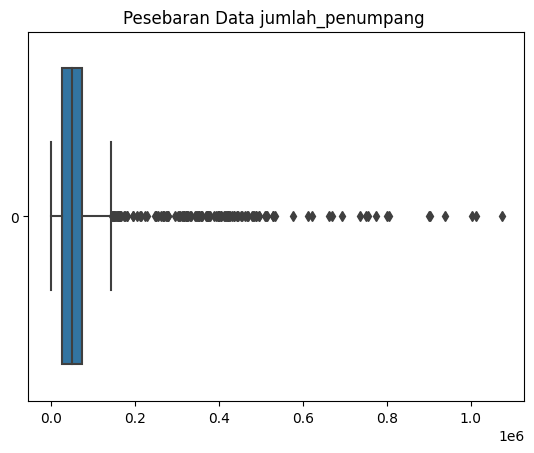

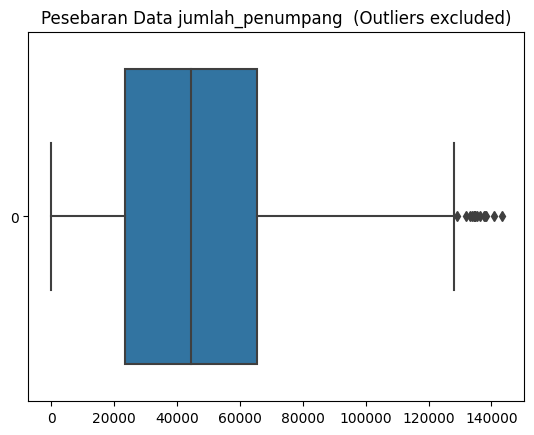

In [455]:
normalCheckShapiro(df['jumlah_penumpang'])
outliersDetail(df,'jumlah_penumpang')

angkutan umum integrasi
The data is not normally distributed.
Jumlah data	= 431
lower bound	= -28210.25
upper bound	= 72215.75
Jumlah data outliers	= 32
Jumlah data (exclude outliers)	= 399


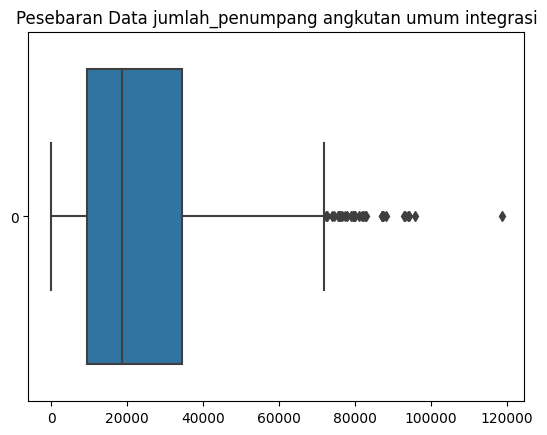

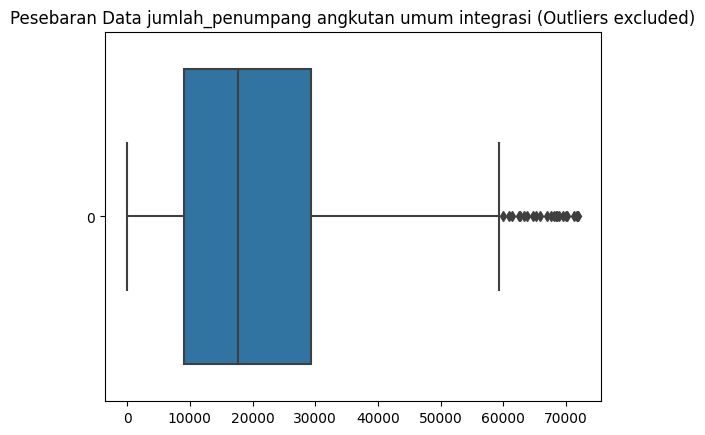

brt
The data is not normally distributed.
Jumlah data	= 143
lower bound	= -142407.25
upper bound	= 803998.75
Jumlah data outliers	= 7
Jumlah data (exclude outliers)	= 136


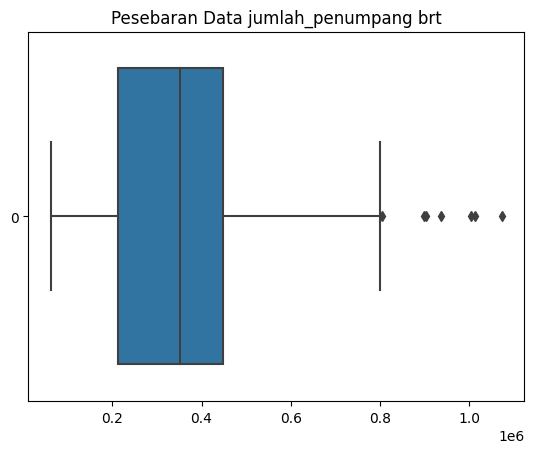

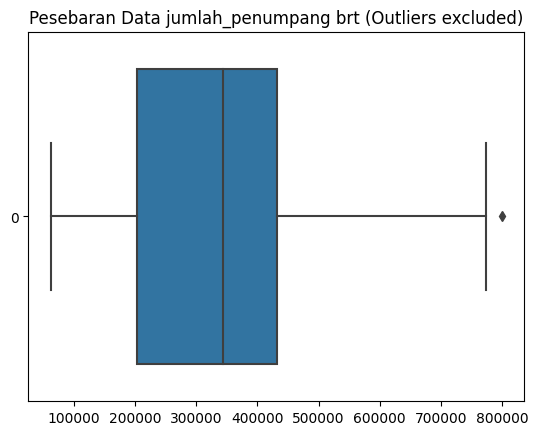

mikrotrans
The data is not normally distributed.
Jumlah data	= 776
lower bound	= -4773.875
upper bound	= 114959.125
Jumlah data outliers	= 27
Jumlah data (exclude outliers)	= 749


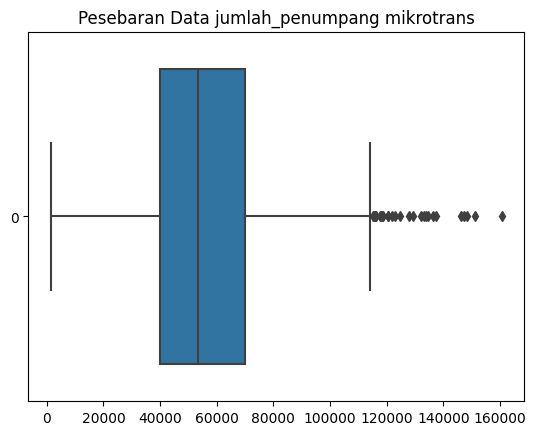

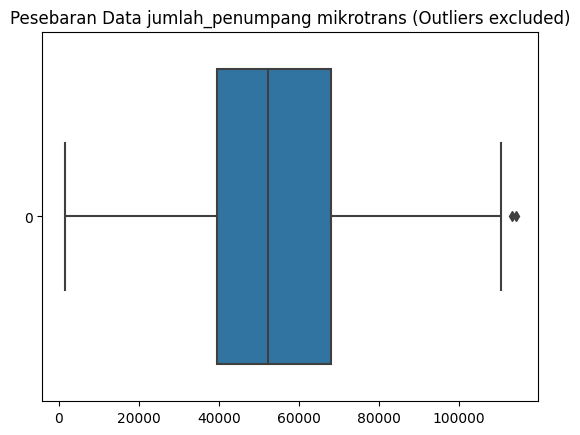

In [456]:
for i in df['jenis'].unique():
    print(i)
    normalCheckShapiro(df[df['jenis']==i]['jumlah_penumpang'])
    dfTemp = df[df['jenis']==i]
    outliersDetail(dfTemp,'jumlah_penumpang',str(i))
    

Pada bagian ini outliers pada data jumlah_penumpang tidak dihilangkan dan hanya untuk menjadi insight untuk waktu lainnya. Dapat disimpulkan berdasrkan grafik data ouliers untuk seluruh jumlah_penumpang ataupun jumlah_penumpang per jenis moda menunjukkan distribusi yang tidak normal dan seluruh grafik memperlihatkan secara umum semua boxplot memiliki karakter right-skewed.

### Duplicate Handling

In [457]:
df[df.duplicated()==True]

,date,jenis,kode_trayek,trayek,jumlah_penumpang


Dari hasil di atas, semua data sudah tidak ada lagi yang terduplikasi. Sehingga, tidak perlu dilakukan penanganan lebih lanjut.

In [458]:
df.describe(exclude='number')

,date,jenis,kode_trayek,trayek
count,1350,1350,1350,1350
unique,NaN,3,131,131
top,NaN,mikrotrans,10K,Tanjung Priok - Senen Via Taman Bmw
freq,NaN,776,11,11
mean,2021-06-02 09:58:24,NaN,NaN,NaN
min,2021-01-01 00:00:00,NaN,NaN,NaN
25%,2021-03-01 00:00:00,NaN,NaN,NaN
50%,2021-06-01 00:00:00,NaN,NaN,NaN
75%,2021-09-01 00:00:00,NaN,NaN,NaN
max,2021-11-01 00:00:00,NaN,NaN,NaN


## Data Preparation Review and Export Cleansed Data

In [459]:
display(df.info(), df.describe(), df.describe(exclude='number'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1350 non-null   datetime64[ns]
 1   jenis             1350 non-null   object        
 2   kode_trayek       1350 non-null   object        
 3   trayek            1350 non-null   object        
 4   jumlah_penumpang  1350 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 52.9+ KB


None

,date,jumlah_penumpang
count,1350,1.350000e+03
mean,2021-06-02 09:58:24,8.080558e+04
min,2021-01-01 00:00:00,1.000000e+00
25%,2021-03-01 00:00:00,2.577725e+04
50%,2021-06-01 00:00:00,4.901750e+04
75%,2021-09-01 00:00:00,7.366325e+04
max,2021-11-01 00:00:00,1.073929e+06
std,NaN,1.232837e+05


,date,jenis,kode_trayek,trayek
count,1350,1350,1350,1350
unique,NaN,3,131,131
top,NaN,mikrotrans,10K,Tanjung Priok - Senen Via Taman Bmw
freq,NaN,776,11,11
mean,2021-06-02 09:58:24,NaN,NaN,NaN
min,2021-01-01 00:00:00,NaN,NaN,NaN
25%,2021-03-01 00:00:00,NaN,NaN,NaN
50%,2021-06-01 00:00:00,NaN,NaN,NaN
75%,2021-09-01 00:00:00,NaN,NaN,NaN
max,2021-11-01 00:00:00,NaN,NaN,NaN


In [460]:
df.to_csv('TransJakartaPassengers2021Cleansed.csv', index=False)

# DATA ANALYST
Akan dijabarkan pada file TransJakartaPassengers2021Analysis.ipynb

# KESIMPULAN DAN REKOMENDASI
Akan dijabarkan pada file TransJakartaPassengers2021Analysis.ipynb